Importing data

In [1]:
import seaborn as sns

import pandas as pd
import warnings

import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


In [2]:
import pandas as pd

pge_data = pd.read_csv('Interconnection_Applications_Dataset_2023-08-31/PGE data.csv')
sce_data = pd.read_csv('Interconnection_Applications_Dataset_2023-08-31/SCE data.csv')
sdge_data = pd.read_csv('Interconnection_Applications_Dataset_2023-08-31/SDGE data.csv')

C:\Users\jiadiz\AppData\Local\Temp\ipykernel_17384\3133552585.py:3: DtypeWarning: Columns (1,2,15,16,17,23,32,34,35,39,40,44,49,50,57,58,60,61,63,64,66,67,69,70,72,73,75,76,78,79,90,91,93,94,96,97,99,100,102,103,105,106) have mixed types. Specify dtype option on import or set low_memory=False.
  pge_data = pd.read_csv('Interconnection_Applications_Dataset_2023-08-31/PGE data.csv')
C:\Users\jiadiz\AppData\Local\Temp\ipykernel_17384\3133552585.py:4: DtypeWarning: Columns (3,15,35,44,49,50,57,58,60,61,84,85,87,88,90,91,93,94,96,97,99,100,102,103,105,106) have mixed types. Specify dtype option on import or set low_memory=False.
  sce_data = pd.read_csv('Interconnection_Applications_Dataset_2023-08-31/SCE data.csv')
C:\Users\jiadiz\AppData\Local\Temp\ipykernel_17384\3133552585.py:5: DtypeWarning: Columns (35,57,58,60,61,63,64,87,88,90,91,93,94,96,97) have mixed types. Specify dtype option on import or set low_memory=False.
  sdge_data = pd.read_csv('Interconnection_Applications_Dataset_2023

In [3]:
solar_data = pd.concat([pge_data,sce_data,sdge_data])

Delete data to save space

In [4]:
del pge_data
del sdge_data
del sce_data

Deleting useless columns

In [5]:
useless_columns = []
for i in range(4, 10):
    useless_columns.append('Generator Model '+ str(i))
    useless_columns.append('Generator Manufacturer '+ str(i))
    useless_columns.append('Generator Quantity ' + str(i))
    useless_columns.append('Inverter Model '+ str(i))
    useless_columns.append('Inverter Quantity '+ str(i))
    
solar_data.drop(useless_columns, axis = 1, inplace = True)

In [6]:
# solar_data['Generator Model 1'].value_counts()[:50]

def compute_panel_type(df, column):
    list_a = []
    for i in df[column]:
#     print(i)
        if pd.isna(i):
            list_a.append('nan')
        elif i == 'Generic Module Model':
            list_a.append('Generic Module Model')
        elif i[:3] == 'SPR':
            list_a.append('SPR')
        elif i[:2] == 'Q.':
            list_a.append('Q.')
        elif i[:2] == 'LR' and str(3).isnumeric():
            list_a.append('LR')
        elif i[:3] == 'JAM':
            list_a.append('JAM')
        elif i[:3] == 'REC':
            list_a.append('REC')
        elif i[:3] == 'JKM':
            list_a.append('JKM')
        elif i[:2] == 'SW':
            list_a.append('SW ')
        elif i[:2] == 'YL':
            list_a.append( 'YL')
        elif i[:2] == 'LG':
            list_a.append("LG")
        elif i[:2] == 'KU':
            list_a.append('KU')
        elif i[:3] == 'TSM':
            list_a.append('TSM')
        elif i[:2] == 'SC' and i[2].isnumeric():
            list_a.append('SC')
        elif i[:2] == 'CS' and i[2].isnumeric():
            list_a.append('CS')
        elif i[:3] == 'TSM':
            list_a.append('TSM')
        elif i[:3] == 'DNA':
            list_a.append('DNA')
        elif i[:3] == 'VBN':
            list_a.append('VBN')
        elif i[:3] == 'VBH':
            list_a.append('VBH')
        elif i[:3] == 'MSE':
            list_a.append('MSE')
        elif i[0] == 'T' and i[1:4].isnumeric():
            list_a.append('T')
        elif i[:3] == 'SIL':
            list_a.append('SIL')
        elif i[:3] == 'BVM':
            list_a.append('BVM')
        elif i[:3] == 'HiS':
            list_a.append('HiS')
        elif i[:3] == 'VBN':
            list_a.append('VBN')
        elif i[:7] == 'Solaria':
            list_a.append('Solaria')
        elif i[:3] == 'EVP':
            list_a.append('EVP')
        elif i[:2] == 'SE' and i[2] == '-':
            list_a.append('SE')
        elif i[:2] == 'ET' and i[2] == '-':
            list_a.append('ET')
        elif i[:2] == 'KD' and i[2].isnumeric():
            list_a.append('KD')
        elif i[:2] == 'PM' and i[2].isnumeric():
            list_a.append('PM')
        elif i[:3] == 'SLA':
            list_a.append('SLA')
        elif i[:3] == 'SST':
            list_a.append('SST')
        elif i[:4] == 'WSMD':
            list_a.append('WSMD')
        elif i[:2] == 'SE' and i[2] == '-':
            list_a.append('SE')
        elif i[:3] == 'STP' :
            list_a.append('STP')
        elif (i[:2] == 'AC' and i[3:12] == 'Powerwall') or ('ACPowerwall' in i):
            list_a.append('AC Powerwall')
        elif i[:7] == 'Protect':
            list_a.append('Protect')
        elif i[:2] == 'ND':
            list_a.append('ND')
        elif i[:2] == 'BP':
            list_a.append('BP')
        elif i[:2] == 'IQ' and i[2].isnumeric():
            list_a.append('IQ')
        elif i[:2] == 'CT' and i[2:5].isnumeric():
            list_a.append('CT')
        elif i[:3] == 'OPT' and i[3:6]:
            list_a.append('OPT')
        elif i[:2] == 'JC' and i[3:6]:
            list_a.append('JC')
        elif i[:2] == 'NU' and i[2]== '-':
            list_a.append('NU-')
        elif 'Sunmodule' in i:
            list_a.append('Sunmodule')
        elif 'Powerwall 2' in i:
            list_a.append('Powerwall')
        elif i[:2] == 'SE' and i[2:6].isnumeric():
            list_a.append('SE0000')
        elif i[:2] == 'FF' and i[2] == '-':
            list_a.append('FF-')
        elif i[:2] == 'NT' and i[2] == '-':
            list_a.append('NT-')
        elif i[:2] == 'NE' and i[2] == '-':
            list_a.append('NE-')
        elif i[:3] == 'ZXM' and i[3].isnumeric():
            list_a.append('ZXM0')
        else:
            list_a.append('other')
    return list_a

In [7]:
solar_data['Panel Type 1'] = compute_panel_type(solar_data, 'Generator Model 1')
solar_data['Panel Type 2'] = compute_panel_type(solar_data, 'Generator Model 2')
solar_data['Panel Type 3'] = compute_panel_type(solar_data, 'Generator Model 3')



Processing data

In [8]:
solar_data['Service Zip'] = solar_data['Service Zip'].astype(str)
solar_data.shape

(1817962, 81)

In [9]:
solar_data[solar_data['Cost/Watt'] != 0 ]['Cost/Watt'].describe()

count    1.428490e+06
mean     4.650938e+00
std      2.224015e+00
min      1.000000e-06
25%      3.665869e+00
50%      4.564256e+00
75%      5.562043e+00
max      5.000000e+01
Name: Cost/Watt, dtype: float64

Preserving only residential solar systesm, since it is what SolarMax sells.

In [10]:
res_data = solar_data[solar_data['Customer Sector'] == 'Residential']
res_data.shape

(1776577, 81)

In [11]:
panel_type = res_data['Generator Model 1'].str.extract(r'(\d{3})')
res_data['panel_size'] = panel_type
res_data['panel_size'] = res_data['panel_size'].astype(float)
res_data['panel_size'].fillna(0, inplace = True)

C:\Users\jiadiz\AppData\Local\Temp\ipykernel_17384\1659833631.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_data['panel_size'] = panel_type
C:\Users\jiadiz\AppData\Local\Temp\ipykernel_17384\1659833631.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_data['panel_size'] = res_data['panel_size'].astype(float)
C:\Users\jiadiz\AppData\Local\Temp\ipykernel_17384\1659833631.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

In [12]:
panel_type = res_data['Generator Model 2'].str.extract(r'(\d{3})')
res_data['panel2_size'] = panel_type
res_data['panel2_size'] = res_data['panel2_size'].astype(float)


C:\Users\jiadiz\AppData\Local\Temp\ipykernel_17384\1109494014.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_data['panel2_size'] = panel_type
C:\Users\jiadiz\AppData\Local\Temp\ipykernel_17384\1109494014.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_data['panel2_size'] = res_data['panel2_size'].astype(float)


In [13]:
res_data['panel2_size'].fillna(0, inplace = True)

C:\Users\jiadiz\AppData\Local\Temp\ipykernel_17384\485262342.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_data['panel2_size'].fillna(0, inplace = True)


In [14]:
panel_type = res_data['Generator Model 3'].str.extract(r'(\d{3})')
res_data['panel3_size'] = panel_type
res_data['panel3_size'] = res_data['panel3_size'].astype(float)

C:\Users\jiadiz\AppData\Local\Temp\ipykernel_17384\4222175946.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_data['panel3_size'] = panel_type
C:\Users\jiadiz\AppData\Local\Temp\ipykernel_17384\4222175946.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_data['panel3_size'] = res_data['panel3_size'].astype(float)


In [15]:
res_data['panel3_size'].fillna(0, inplace = True)

C:\Users\jiadiz\AppData\Local\Temp\ipykernel_17384\2118216981.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_data['panel3_size'].fillna(0, inplace = True)


In [16]:
res_data.shape

(1776577, 84)

Standardizing the County column

In [17]:
lista = []
for i in res_data['Service County']:
    lista.append(i.lower())
res_data['Service County'] = lista

lista = []
for i in res_data['Service City']:
    lista.append(str(i).lower())
res_data['Service City'] = lista
# Deleting the data in 'alpine' County, because 
res_data = res_data[res_data['Service County'] != 'alpine']

C:\Users\jiadiz\AppData\Local\Temp\ipykernel_17384\3821149939.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_data['Service County'] = lista
C:\Users\jiadiz\AppData\Local\Temp\ipykernel_17384\3821149939.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_data['Service City'] = lista


Deleting unreasonable data points. Inverter/system Size ratio cannot be negative, nor can it be 0 or lower than 0.025

In [18]:
res_data = res_data[res_data['System Size DC'] > 0]
print(res_data.shape)
# res_data= res_data[res_data['Total System Cost'] > 0]

res_data['Inverter_value_missing'] = res_data['Inverter Size (kW AC)'].isnull().astype(int)
print(res_data.shape)
res_data['Inverter Size (kW AC)'].fillna(-999, inplace=True)
print(res_data.shape)



(1756128, 84)
(1756128, 85)
(1756128, 85)


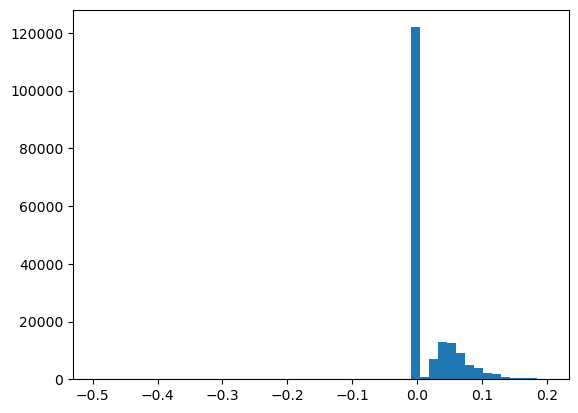

In [19]:
res_data['inverter_solar_ratio'] = res_data['Inverter Size (kW AC)']/res_data['System Size AC']
# plt.hist(exp[exp['indi'] < 0.5][exp['inverter_solar_ratio'] > 0.05]['indi'], bins = 100)
plt.hist(res_data['inverter_solar_ratio'][(res_data['Inverter Size (kW AC)']!=-999)&(res_data['inverter_solar_ratio'] < 0.2)&(res_data['inverter_solar_ratio'] >-0.5)], bins = 50)
plt.show()

In [20]:
res_data['Inverter_is_0'] = res_data['Inverter Size (kW AC)'].apply(lambda x:x== 0)
res_data['abnormally_small_inverter'] = res_data['inverter_solar_ratio'].apply(lambda x:(x > 0)&(x<0.2))

In [21]:
res_data['Itc_value_missing'] = res_data['Itc Cost Basis'].isnull().astype(int)
print(res_data.shape)
res_data['Itc Cost Basis'].fillna(-99999, inplace=True)
print(res_data.shape)


(1756128, 89)
(1756128, 89)


In [22]:
res_data.columns

Index(['Application Id', 'Preceding Id', 'Superceding Id',
       'Matched CSI Application Number', 'Application Status', 'Utility',
       'Service City', 'Service Zip', 'Service County', 'Technology Type',
       'System Size DC', 'System Size AC', 'Storage Capacity (kWh)',
       'Storage Size (kW AC)', 'Inverter Size (kW AC)', 'Tilt', 'Azimuth',
       'Mounting Method', 'Tracking', 'Customer Sector', 'App Received Date',
       'App Complete Date', 'App Approved Date', 'Decommissioned Date',
       'Self Installer', 'Installer Name', 'Installer Phone', 'Installer City',
       'Installer State', 'Installer Zip', 'CSLB Number', 'Third Party Owned',
       'Third Party Owned Type', 'Third Party Name', 'Pace Financed',
       'Pace Financier', 'Electric Vehicle', 'Electric Vehicle Count',
       'System Output Monitoring', 'System Output Reports To Vendor?',
       'System Output Monitoring Provider', 'Total System Cost',
       'Itc Cost Basis', 'Cost/Watt', 'NEM Tariff', 'Interconn

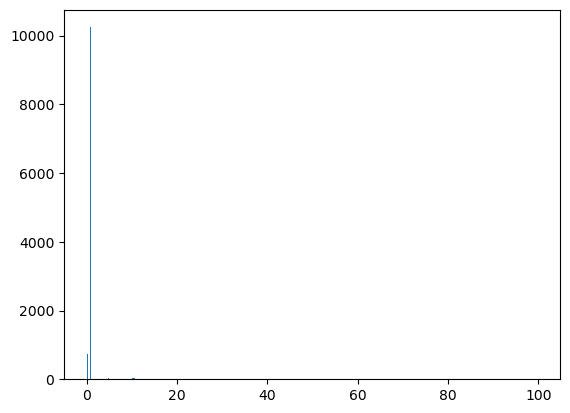

In [23]:
plt.hist(res_data['Itc Cost Basis'][(res_data['Itc Cost Basis'] < 100) & (res_data['Itc Cost Basis'] > 0)], bins = 300)
plt.show()

In [24]:
res_data['Itc Cost Basis'].value_counts()

Itc Cost Basis
-99999.00    654854
 0.00        649863
 1.00         10240
 21336.00      3071
 9728.00       2063
              ...  
 38996.40         1
 47683.35         1
 19426.30         1
 45664.40         1
 35780.00         1
Name: count, Length: 148516, dtype: int64

In [25]:
res_data['weird_itc'] = res_data.apply(lambda x:(x['Inverter Size (kW AC)']/x['System Size DC'] < 0.025) & (x['Inverter Size (kW AC)'] != -999), axis = 1)

In [26]:

res_data ['Storage Size (kW AC)'] = res_data ['Storage Size (kW AC)'].fillna(0)

In [27]:
res_data.shape

(1756128, 90)

In [28]:
res_data['Inverter Size (kW AC)'].describe()

count    1.756128e+06
mean    -3.577149e+02
std      4.824202e+02
min     -8.149412e+03
25%     -9.990000e+02
50%      2.800000e+00
75%      5.235000e+00
max      7.625000e+03
Name: Inverter Size (kW AC), dtype: float64

In [29]:
exp = res_data[res_data['Total System Cost'] <100]

In [30]:
res_data['real_cost'] = res_data['Cost/Watt']*res_data['System Size AC']*1000 

In [31]:
res_data[['real_cost','Total System Cost']]

,real_cost,Total System Cost
5,NaN,NaN
18,NaN,NaN
23,NaN,NaN
265,NaN,NaN
266,NaN,NaN
...,...,...
318815,4645.998784,NaN
318816,21708.997902,21709.0
318817,11862.998784,11863.0
318818,6836.998818,6837.0


In [32]:
(res_data['Total System Cost']/res_data['real_cost'] > 0 ).sum()

984944

In [33]:
res_data['cost_to_hyp_ratio'] = res_data['Total System Cost']/res_data['real_cost'] 

In [34]:
res_data.shape

(1756128, 92)

In [35]:
res_data['Total System Cost'] = res_data.apply(lambda x: np.nan if x['cost_to_hyp_ratio'] < 0.5 else x['Total System Cost'], axis = 1)

In [36]:
# res_data = res_data[res_data['Total System Cost'] > 100]

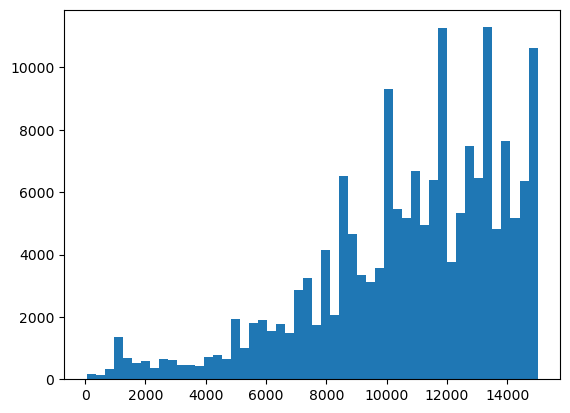

In [37]:
plt.hist(res_data['Total System Cost'][(res_data['Total System Cost'] > 50)&(res_data['Total System Cost'] < 15000)], bins = 50)
plt.show()

Processing company titles

In [38]:
res_data.shape

(1756128, 92)

In [39]:
import pandas as pd

# Assuming 'CompetitorStudy' is a DataFrame and it's already loaded in Python

# Create a dictionary mapping original strings to their replacements
replacements = {
    "california premier solar": "CaliforniaPremierSolar",
    "california solar systems": "CaliforniaSolarSystems",
    "clean energy solutions inc": "CleanEnergySolutionsInc",
    "energy remodeling": "EnergyRemodeling",
    "energyservicepartners": "energy service partners",
    "green convergence": "GreenConvergence",
    "home energy systems": "HomeEnergySystems",
    "new day solar": "NewDaySolar",
    "new power": "NewPower",
    "petersendean": "petersen dean",
    "solar 360": "solar360",
    "solaroptimum inc": "SolarOptimum",
    "solar permit": "SolarPermit",
    "solar service": "SolarService",
    "solar solutions": "SolarSolutions",
    "solar universie": "SolarUniverse",
    "Solar watt": "SolarWatt",
    "solar west": "SolarWest",
    "solar-360": "Solar360",
    "solarcitymh": "SolarCity",
    "south west": "SouthWest",
    "sun bees ": "SunBees",
    "sun energy": "SunEnergy",
    "sun solar": "SunSolar",
    "1st light energy inc": "Firstlight",
    "solar optimum": "SolarOptimum",
    "sunrun installation services inc":"Sunrun",
    "sunrun installation services, inc.":"Sunun",
    "solarcity corporation":"SolarCity",
    "tesla energy operations, inc.":"Tesla",
    "tesla energy operations inc":"Tesla",
    "SolarOptimum":"SolarOptimum",
    "n r g ":'nrg',
    "west coast":'WestCoast',
    "american array":"AmericanArray",
    "quality home":"QualityHomes",
    "quality homes":'QualityHomes',
    "solar 4 america":'Solar4America',
    "solar negotiators":"SolarNegotiators",
    "solar savings direct":"SolarSavingsDirect",
    "solar technologies":'SolarTechnologies',
    "solartech":'SolarTech',
    "west coast":'WestCoast',
    "american solar direct":"AmericanSolarDirect",
    "california solar electric co":"CaliforniaSolarElectric",
    "energy concepts":"EnergyConcepts",
    "energy savings pros":'EnergySavingPros',
    "energy service partners":"EnergyServicePartners",
    }

res_data['Installer Name'] = res_data['Installer Name'].apply(lambda x: str(x).lower())

# Process replacements using a while loop
keys = list(replacements.keys())
while keys:
    key = keys.pop()
    res_data['Installer Name'] = res_data['Installer Name'].str.replace(key, replacements[key]).str.lower()


In [40]:
res_data['Installer Name'].str.lower()

5                               solarcity
18                         solarcity corp
23                       occidental power
265                                akeena
266                  lavezzo construction
                       ...               
318815                         zing solar
318816                          solarcity
318817    semper solaris construction inc
318818                          solarcity
318819                          solarcity
Name: Installer Name, Length: 1756128, dtype: object

In [41]:
series1 = pd.Series(res_data['Installer Name'].value_counts()[:100].index.sort_values())
series2 = pd.Series(res_data['Installer Name'].value_counts()[:150].index.sort_values())

In [42]:
series2[~series2.isin(series1)][40:50]

99                                   solaroptimum.
105    solgen construction llc dba solgen electric
107                            sonray construction
113                       sungate energy solutions
115                                 sungevity inc.
123                  sunpower corporation, systems
132                                swss electrical
135                   tesla energy operations, inc
136                         tesla military housing
148                            westcoast solar inc
Name: Installer Name, dtype: object

In [43]:
res_data['Installer Name'].value_counts()[50:60]

Installer Name
sunline energy inc.          4333
solcius                      4329
sunsolar energy solutions    4039
v3 electric                  3852
lennar                       3811
solarnegotiators             3784
freedom solar co             3783
esp contracting              3686
infinity energy              3646
sunergy construction inc     3596
Name: count, dtype: int64

In [44]:

res_data['Installer Name'] =  res_data['Installer Name'].apply(lambda x: x.split()[0])

Top 50 companies will each be categorical variable, the rest will be classified as 'others'.

In [45]:
market_value = res_data['Installer Name'].value_counts().sum()

top_50_companies = pd.DataFrame(res_data['Installer Name'].value_counts()/market_value)[:100].index

res_data['Installer Name'] = res_data['Installer Name'].apply(lambda x: x if x in top_50_companies else 'other') 

In [46]:
res_data.shape

(1756128, 92)

In [47]:
reserve = res_data.copy()

### Importing zip code information.

In [48]:
zip_info = pd.read_csv('zip2021.csv', dtype = {'zip':str})

C:\Users\jiadiz\AppData\Local\Temp\ipykernel_17384\3609082138.py:1: DtypeWarning: Columns (2,3,4,5,66,67,68,69,130,131,132,133,194,195,196,197) have mixed types. Specify dtype option on import or set low_memory=False.
  zip_info = pd.read_csv('zip2021.csv', dtype = {'zip':str})


In [49]:
res_data['Service Zip'] = res_data['Service Zip'].str.replace('.0','')

res_data['Installer Zip'] = res_data['Installer Zip'].astype(str).str.replace('.0','')

In [50]:
zip_info.columns = zip_info.iloc[0,:]

In [51]:
zip_info.drop([0],axis = 0, inplace = True)

In [52]:
zip_info['zip'] = zip_info['Geographic Area Name'].apply(lambda x:x[-5:])

In [53]:
columns = []
for i in zip_info.columns:
    if (('median' ) in str(i).lower() or ('mean' ) in str(i).lower() )and 'nonfamily' not in str(i).lower():
        columns.append(i)
    if ('population') in str(i).lower():
        columns.append(i)
zip_info[columns]

,Estimate!!Households!!Median income (dollars),Annotation of Estimate!!Households!!Median income (dollars),Margin of Error!!Households!!Median income (dollars),Annotation of Margin of Error!!Households!!Median income (dollars),Estimate!!Households!!Mean income (dollars),Annotation of Estimate!!Households!!Mean income (dollars),Margin of Error!!Households!!Mean income (dollars),Annotation of Margin of Error!!Households!!Mean income (dollars),Estimate!!Families!!Median income (dollars),Margin of Error!!Families!!Median income (dollars),...,Margin of Error!!Families!!Mean income (dollars),Annotation of Margin of Error!!Families!!Mean income (dollars),Estimate!!Married-couple families!!Median income (dollars),Margin of Error!!Married-couple families!!Median income (dollars),Annotation of Margin of Error!!Married-couple families!!Median income (dollars),Annotation of Estimate!!Married-couple families!!Median income (dollars),Estimate!!Married-couple families!!Mean income (dollars),Margin of Error!!Married-couple families!!Mean income (dollars),Annotation of Margin of Error!!Married-couple families!!Mean income (dollars),Annotation of Estimate!!Married-couple families!!Mean income (dollars)
1,15292,NaN,1299,NaN,19468,NaN,1438,NaN,16283,1177,...,1762,NaN,19060,2833,NaN,NaN,N,N,N,N
2,18716,NaN,1340,NaN,27778,NaN,1581,NaN,23199,1956,...,2123,NaN,26600,2215,NaN,NaN,N,N,N,N
3,16789,NaN,966,NaN,29102,NaN,2380,NaN,21537,1844,...,3568,NaN,35043,3079,NaN,NaN,N,N,N,N
4,18835,NaN,2837,NaN,22236,NaN,2061,NaN,21044,3602,...,2782,NaN,25455,8218,NaN,NaN,N,N,N,N
5,21239,NaN,1919,NaN,29555,NaN,2441,NaN,25097,2124,...,3558,NaN,28653,6409,NaN,NaN,N,N,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33770,-,-,**,**,N,N,N,N,-,**,...,**,**,-,**,**,-,-,**,**,-
33771,70625,NaN,18552,NaN,83366,NaN,12662,NaN,79375,13702,...,13142,NaN,95417,26113,NaN,NaN,N,N,N,N
33772,58229,NaN,15143,NaN,71467,NaN,8574,NaN,80625,23840,...,9663,NaN,98333,22840,NaN,NaN,N,N,N,N
33773,-,-,**,**,N,N,N,N,-,**,...,**,**,-,**,**,-,-,**,**,-


In [54]:
zip_income = zip_info[['zip','Estimate!!Households!!Median income (dollars)','Estimate!!Households!!Mean income (dollars)']]
zip_income.columns = ['zip','median_income','mean_income']

In [55]:
zip_income['median_income'] = zip_income['median_income'].str.replace(',','')
zip_income['mean_income'] = zip_income['mean_income'].str.replace(',','')

zip_income['median_income'] = zip_income['median_income'].str.replace('+','')
zip_income['mean_income'] = zip_income['mean_income'].str.replace('+','')

zip_income['median_income'] = zip_income['median_income'].str.replace('-','')
zip_income['mean_income'] = zip_income['mean_income'].str.replace('-','')

C:\Users\jiadiz\AppData\Local\Temp\ipykernel_17384\4196980375.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zip_income['median_income'] = zip_income['median_income'].str.replace(',','')
C:\Users\jiadiz\AppData\Local\Temp\ipykernel_17384\4196980375.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zip_income['mean_income'] = zip_income['mean_income'].str.replace(',','')
C:\Users\jiadiz\AppData\Local\Temp\ipykernel_17384\4196980375.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy o

In [56]:
zip_income['median_income'] = zip_income['median_income'].apply(lambda x:np.nan if x == '-' or x== 'N' else x)
zip_income['mean_income'] = zip_income['mean_income'].apply(lambda x:np.nan if x == '-' or x== 'N' else x)

C:\Users\jiadiz\AppData\Local\Temp\ipykernel_17384\964615316.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zip_income['median_income'] = zip_income['median_income'].apply(lambda x:np.nan if x == '-' or x== 'N' else x)
C:\Users\jiadiz\AppData\Local\Temp\ipykernel_17384\964615316.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zip_income['mean_income'] = zip_income['mean_income'].apply(lambda x:np.nan if x == '-' or x== 'N' else x)


In [57]:
zip_income['mean_income'].fillna(-9999, inplace = True)
zip_income['median_income'].fillna(-9999, inplace = True)

C:\Users\jiadiz\AppData\Local\Temp\ipykernel_17384\3462772560.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zip_income['mean_income'].fillna(-9999, inplace = True)
C:\Users\jiadiz\AppData\Local\Temp\ipykernel_17384\3462772560.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zip_income['median_income'].fillna(-9999, inplace = True)


In [58]:
zip_income['median_income'].replace('',np.nan, inplace = True)
zip_income['mean_income'].replace('',np.nan, inplace = True)

C:\Users\jiadiz\AppData\Local\Temp\ipykernel_17384\2077990566.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zip_income['median_income'].replace('',np.nan, inplace = True)
C:\Users\jiadiz\AppData\Local\Temp\ipykernel_17384\2077990566.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zip_income['mean_income'].replace('',np.nan, inplace = True)


In [59]:
zip_income['median_income'] = zip_income['median_income'].astype(float)
zip_income['mean_income'] = zip_income['mean_income'].astype(float)

C:\Users\jiadiz\AppData\Local\Temp\ipykernel_17384\1825553813.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zip_income['median_income'] = zip_income['median_income'].astype(float)
C:\Users\jiadiz\AppData\Local\Temp\ipykernel_17384\1825553813.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zip_income['mean_income'] = zip_income['mean_income'].astype(float)


In [60]:
res_data = pd.merge(res_data, zip_income, left_on = 'Service Zip', right_on = 'zip', how ='left')

In [61]:
res_data['median_income'].fillna(-999,inplace = True)
res_data['mean_income'].fillna(-999,inplace = True)

In [62]:
res_data.shape

(1756128, 95)

Importing longtitude and latitude

In [63]:
zips = pd.read_csv('uszips.csv', dtype = {'zip':str})


In [64]:
installer_zips = zips.copy()
installer_zips.columns = ['zip', 'installer_lat','installer_lng']

In [65]:
res_data = pd.merge(res_data, installer_zips, left_on = 'Installer Zip', right_on = 'zip', how = 'left')

In [66]:
res_data = pd.merge(res_data, zips, left_on = 'Service Zip', right_on = 'zip', how = 'left')

In [67]:
res_data.isna().sum()

Application Id                          0
Preceding Id                      1683402
Superceding Id                    1656166
Matched CSI Application Number    1624530
Application Status                      0
                                   ...   
installer_lat                      171139
installer_lng                      171139
zip                                 21280
lat                                 21280
lng                                 21280
Length: 101, dtype: int64

In [68]:
res_data['App Received Date'] = pd.to_datetime(res_data['App Received Date'])

# Extract year, month, and day
res_data['year'] = res_data['App Received Date'].dt.year
res_data['month'] = res_data['App Received Date'].dt.month
res_data['day'] = res_data['App Received Date'].dt.day

In [69]:
res_data.columns

Index(['Application Id', 'Preceding Id', 'Superceding Id',
       'Matched CSI Application Number', 'Application Status', 'Utility',
       'Service City', 'Service Zip', 'Service County', 'Technology Type',
       ...
       'mean_income', 'zip_y', 'installer_lat', 'installer_lng', 'zip', 'lat',
       'lng', 'year', 'month', 'day'],
      dtype='object', length=104)

In [70]:
categorical_features = ['Service County', 'Installer Name','Inverter_value_missing',
                                                                'Itc_value_missing','weird_itc', 'Inverter_is_0',
                                                                'abnormally_small_inverter']

for col in categorical_features:
    res_data[col] = res_data[col].astype('string')

In [71]:
exp_data = res_data[['System Size AC','Service County',
                     'lat', 'lng','Cost/Watt',
                     'Inverter Size (kW AC)',
                    'Storage Size (kW AC)','Installer Name','year','month',
                     'day', 'panel_size','panel2_size','panel3_size',
                    'installer_lat','installer_lng','Generator Quantity 1', 
                     'Generator Quantity 2','Inverter Quantity 1',
                     'Generator Quantity 3','Inverter_value_missing','Itc_value_missing','weird_itc','Inverter_is_0',
                    'abnormally_small_inverter','median_income','mean_income']]

#'Total System Cost','Itc Cost Basis',                     'NEM Tariff'

In [72]:
selected_features = exp_data.columns[exp_data.columns != 'Cost/Watt']

In [73]:
exp = pd.DataFrame({"1":exp_data['System Size AC'],"2":exp_data['panel_size']*exp_data['Generator Quantity 1']/1000})
(exp['1']/exp['2']).dropna().sample(100)

1165435    0.876333
1453091    0.865051
708677     0.903160
1610709    0.901136
443055     0.903199
             ...   
1072279    0.915278
170361     0.860651
1546994    0.909062
1218135    1.348026
272452     0.891667
Length: 100, dtype: float64

In [74]:
exp_data['Generator Quantity 3'].fillna(0, inplace = True)
exp_data['Generator Quantity 2'].fillna(0, inplace = True)
exp_data['Generator Quantity 1'].fillna(0, inplace = True)
# exp_data['NEM Tariff'].fillna('unknown', inplace = True)
exp_data['lat'].fillna(0, inplace = True)
exp_data['lng'].fillna(0, inplace = True)
exp_data['installer_lat'].fillna(0, inplace = True)
exp_data['installer_lng'].fillna(0, inplace = True)
# exp_data['Total System Cost'].fillna(-99999, inplace = True)

C:\Users\jiadiz\AppData\Local\Temp\ipykernel_17384\1565089017.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_data['Generator Quantity 3'].fillna(0, inplace = True)
C:\Users\jiadiz\AppData\Local\Temp\ipykernel_17384\1565089017.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_data['Generator Quantity 2'].fillna(0, inplace = True)
C:\Users\jiadiz\AppData\Local\Temp\ipykernel_17384\1565089017.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

In [75]:
exp_data[exp_data['Generator Quantity 1'].isna()]['System Size AC']

Series([], Name: System Size AC, dtype: float64)

In [76]:
# exp_data['NEM Tariff'] = exp_data['NEM Tariff'].astype(str)
exp_data['Generator Quantity 1'] = exp_data['Generator Quantity 1'].astype(float)
exp_data['Generator Quantity 2'] = exp_data['Generator Quantity 2'].astype(float)
exp_data['Generator Quantity 3'] = exp_data['Generator Quantity 3'].astype(float)
exp_data['Inverter Quantity 1'] = exp_data['Generator Quantity 1'].astype(float)

C:\Users\jiadiz\AppData\Local\Temp\ipykernel_17384\3540609467.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_data['Generator Quantity 1'] = exp_data['Generator Quantity 1'].astype(float)
C:\Users\jiadiz\AppData\Local\Temp\ipykernel_17384\3540609467.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_data['Generator Quantity 2'] = exp_data['Generator Quantity 2'].astype(float)
C:\Users\jiadiz\AppData\Local\Temp\ipykernel_17384\3540609467.py:4: SettingWithCopyWarning: 
A value is trying to be set

In [77]:
exp_data.dropna(subset = ['year','month','day'], inplace = True)

C:\Users\jiadiz\AppData\Local\Temp\ipykernel_17384\2260275419.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_data.dropna(subset = ['year','month','day'], inplace = True)


In [78]:
exp_data.isna().sum()

System Size AC                    0
Service County                    0
lat                               0
lng                               0
Cost/Watt                    351144
Inverter Size (kW AC)             0
Storage Size (kW AC)              0
Installer Name                    0
year                              0
month                             0
day                               0
panel_size                        0
panel2_size                       0
panel3_size                       0
installer_lat                     0
installer_lng                     0
Generator Quantity 1              0
Generator Quantity 2              0
Inverter Quantity 1               0
Generator Quantity 3              0
Inverter_value_missing            0
Itc_value_missing                 0
weird_itc                         0
Inverter_is_0                     0
abnormally_small_inverter         0
median_income                     0
mean_income                       0
dtype: int64

In [79]:
categorical_features = ['Service County', 'Installer Name','Inverter_value_missing',
                                                                'Itc_value_missing','weird_itc', 'Inverter_is_0',
                                                                'abnormally_small_inverter']

for col in categorical_features:
    exp_data[col] = exp_data[col].astype('category')

C:\Users\jiadiz\AppData\Local\Temp\ipykernel_17384\2057595838.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_data[col] = exp_data[col].astype('category')


In [80]:
to_be_filled = exp_data[exp_data['Cost/Watt'].isna()]

In [81]:
exp_data = exp_data.dropna()

In [82]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

# Assuming exp_data is defined and has the required columns
y = exp_data['Cost/Watt']
X = exp_data.drop(['Cost/Watt'], axis=1)

# Make sure categorical_features is defined correctly
categorical_features = ['Service County', 'Installer Name','Inverter_value_missing',
                                                                'Itc_value_missing','weird_itc', 'Inverter_is_0',
                                                                'abnormally_small_inverter']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

params = {
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'n_estimators': 1000,
    'lambda_l2': 1,
    'categorical_feature': categorical_features
}

mean_model = lgb.LGBMRegressor(**params)
mean_model.fit(X_train, y_train)

quantiles = np.linspace(0.05, 0.95, 19)
models = {}

for q in quantiles:
    print(f"Training model for {q * 100}% quantile")
    params['objective'] = 'quantile'
    params['alpha'] = q
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    models[f"quantile_{int(q * 100)}"] = model

    

C:\Users\jiadiz\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
C:\Users\jiadiz\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
Training model for 5.0% quantile


C:\Users\jiadiz\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
C:\Users\jiadiz\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training model for 10.0% quantile


C:\Users\jiadiz\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
C:\Users\jiadiz\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training model for 15.0% quantile


C:\Users\jiadiz\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
C:\Users\jiadiz\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training model for 20.0% quantile


C:\Users\jiadiz\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
C:\Users\jiadiz\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training model for 25.0% quantile


C:\Users\jiadiz\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
C:\Users\jiadiz\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training model for 30.0% quantile


C:\Users\jiadiz\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
C:\Users\jiadiz\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training model for 35.0% quantile


C:\Users\jiadiz\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
C:\Users\jiadiz\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training model for 40.0% quantile


C:\Users\jiadiz\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
C:\Users\jiadiz\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training model for 44.99999999999999% quantile


C:\Users\jiadiz\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
C:\Users\jiadiz\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training model for 49.99999999999999% quantile


C:\Users\jiadiz\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
C:\Users\jiadiz\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training model for 54.99999999999999% quantile


C:\Users\jiadiz\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
C:\Users\jiadiz\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training model for 60.0% quantile


C:\Users\jiadiz\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
C:\Users\jiadiz\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training model for 65.0% quantile


C:\Users\jiadiz\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
C:\Users\jiadiz\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training model for 70.0% quantile


C:\Users\jiadiz\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
C:\Users\jiadiz\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


KeyboardInterrupt: 

In [ ]:
quantiles = np.linspace(0.05, 0.95, 19)

In [ ]:
extra_two_models = [0.02, 0.98]
for q in extra_two_models:
    print(f"Training model for {q * 100}% quantile")
    params['objective'] = 'quantile'
    params['alpha'] = q
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    models[f"quantile_{int(q * 100)}"] = model


In [ ]:
y_pred_mean = mean_model.predict(X_test)

In [1556]:
feature_importance = pd.DataFrame({'columns': X.columns, 'importance':mean_model.feature_importances_}).sort_values('importance', ascending = False)[:]

In [1557]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred_mean)
print(f"r2: {r2}")

r2: 0.42494031354673567


In [1558]:
models

{'quantile_5': LGBMRegressor(alpha=0.05,
               categorical_feature=['Service County', 'Installer Name',
                                    'Inverter_value_missing',
                                    'Itc_value_missing', 'weird_itc',
                                    'Inverter_is_0',
                                    'abnormally_small_inverter'],
               lambda_l2=1, learning_rate=0.05, metric='rmse', n_estimators=1000,
               objective='quantile'),
 'quantile_10': LGBMRegressor(alpha=0.1,
               categorical_feature=['Service County', 'Installer Name',
                                    'Inverter_value_missing',
                                    'Itc_value_missing', 'weird_itc',
                                    'Inverter_is_0',
                                    'abnormally_small_inverter'],
               lambda_l2=1, learning_rate=0.05, metric='rmse', n_estimators=1000,
               objective='quantile'),
 'quantile_15': LGBMRegressor(al

In [285]:
new_df.columns.isin(mean_model.feature_name_)

array([False, False,  True,  True, False, False, False, False,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
       False, False])

In [286]:
X.columns[~X.columns.isin(models[f"quantile_{q}"].feature_name_)]

Index(['System Size AC', 'Service County', 'Inverter Size (kW AC)',
       'NEM Tariff', 'Storage Size (kW AC)', 'Installer Name',
       'Generator Quantity 1', 'Generator Quantity 2', 'Inverter Quantity 1',
       'Generator Quantity 3'],
      dtype='object')

In [287]:
x = pd.Series(X.columns).str.replace('_',' ')

In [288]:
y = pd.Series(models[f"quantile_{q}"].feature_name_).str.replace('_',' ')

In [290]:
X = exp_data.drop(['Cost/Watt'], axis = 1)
feature_importance = pd.DataFrame({'columns': X.columns, 'importance':mean_model.feature_importances_}).sort_values('importance', ascending = False)[:]

In [1613]:
temp_test_X

,System Size AC,Service County,lat,lng,Inverter Size (kW AC),Storage Size (kW AC),Installer Name,year,month,day,...,panel2_size,panel3_size,installer_lat,installer_lng,Generator Quantity 1,Generator Quantity 2,Generator Quantity 3,Itc_value_missing,median_income,mean_income
797075,7.608,kern,35.34266,-119.06461,6.132,0.0,other,2023.0,4.0,3.0,...,0.0,0.0,35.38500,-119.23741,21.0,0.0,0.0,0,54572.0,71877.0
267315,3.547,solano,38.24112,-122.12142,3.990,0.0,sunun,2017.0,1.0,4.0,...,0.0,0.0,35.23539,-120.61834,15.0,0.0,0.0,0,121478.0,146989.0
321495,6.880,tuolumne,37.98484,-120.34515,7.625,0.0,other,2017.0,9.0,11.0,...,0.0,0.0,37.98927,-120.26272,26.0,0.0,0.0,0,65245.0,87892.0
571557,5.325,contra costa,37.97999,-122.15368,3.747,0.0,vivint,2021.0,6.0,4.0,...,325.0,0.0,40.41209,-111.87377,20.0,18.0,0.0,0,110971.0,138204.0
653999,11.622,solano,38.09756,-122.13189,21.375,10.0,tesla,2022.0,4.0,25.0,...,301.0,0.0,37.50653,-121.96361,228.0,2.0,0.0,0,118228.0,139585.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1551118,5.512,san diego,32.90665,-116.88875,5.052,0.0,bright,2019.0,11.0,18.0,...,0.0,0.0,42.19689,-71.84549,20.0,0.0,0.0,0,88820.0,104912.0
764779,13.885,santa clara,37.25624,-122.05151,12.250,0.0,your,2023.0,4.0,11.0,...,0.0,0.0,37.75902,-121.76026,35.0,0.0,0.0,0,222235.0,308151.0
1285599,7.928,orange,33.86871,-117.92914,-999.000,0.0,other,2023.0,4.0,7.0,...,0.0,0.0,33.84616,-118.01176,22.0,0.0,0.0,1,79593.0,96051.0
1292793,5.208,orange,33.72833,-117.79753,-999.000,0.0,other,2018.0,7.0,25.0,...,0.0,0.0,33.76399,-117.93153,18.0,0.0,0.0,1,123909.0,167932.0


In [1608]:
temp_y = y.copy()
temp_X = X.copy()
temp_test_X = X_test.copy()

temp_X.drop(['Inverter Quantity 1','Inverter_value_missing','weird_itc','abnormally_small_inverter','Inverter_is_0'], axis = 1, inplace = True)
temp_test_X.drop(['Inverter Quantity 1','Inverter_value_missing','weird_itc','abnormally_small_inverter','Inverter_is_0'], axis = 1, inplace = True)

In [1614]:
 y_pred_temp

array([9.59871761, 5.25166169, 6.85087237, ..., 8.52062934, 6.80647029,
       6.21305241])

In [1616]:

# Make sure categorical_features is defined correctly
categorical_features = ['Service County', 'Installer Name','Inverter_value_missing',
                                                                'Itc_value_missing','weird_itc', 'Inverter_is_0',
                                                                'abnormally_small_inverter']

mean_model = lgb.LGBMRegressor(**params)
mean_model.fit(X_train, y_train)
y_pred_temp = mean_model.predict(X_test )
r2 = r2_score(y_test, y_pred_temp)
print(f"r2: {r2}")

[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
r2: -2.2424498311952186


In [1611]:

# Make sure categorical_features is defined correctly
categorical_features = ['Service County', 'Installer Name','Inverter_value_missing',
                                                                'Itc_value_missing','weird_itc', 'Inverter_is_0',
                                                                'abnormally_small_inverter']

mean_model = lgb.LGBMRegressor(**params)
mean_model.fit(temp_X, temp_y)
y_pred_temp = mean_model.predict(temp_test_X )
r2 = r2_score(y_test, y_pred_temp)
print(f"r2: {r2}")

[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
r2: -2.2905593478408646


In [1612]:
y_pred_temp = mean_model.predict(temp_test_X )
r2 = r2_score(y_test, y_pred_temp)
print(f"r2: {r2}")

r2: -2.2905593478408646


In [456]:
daf = X[X['Installer Name'] == 'solarmax'].iloc[:1]

In [435]:
models[f"quantile_{q}"].predict(daf)

array([2.4909599])

In [454]:
daf[['installer_lat', 'installer_lng']] = [40.49865,-74.53284  ]

In [455]:
mean_model.predict(daf)

array([4.0186395])

In [ ]:
models[f"quantile_{q}"].predict(daf)

In [471]:
sum_tab = X[X['Installer Name'] == 'sunrun'][['installer_lat','installer_lng']].value_counts()
summ = sum_tab.sum()
instal_loc_dis = sum_tab/summ
instal_locs= instal_loc_dis[instal_loc_dis >= 0.05]
for i in instal_locs.index:
    

MultiIndex([(40.49865,  -74.53284),
            (37.79144, -122.40211),
            (35.23539, -120.61834)],
           names=['installer_lat', 'installer_lng'])

In [291]:
to_be_filled.drop(['Cost/Watt'], axis = 1, inplace = True)

In [292]:
to_be_filled['Cost/Watt'] = mean_model.predict(to_be_filled)

In [293]:
new_df = pd.concat([exp_data, to_be_filled], axis=0)

In [ ]:
# missing_cost_per_watt = to_be_filled['Cost/Watt'] 

# # Fill the DataFrame's x-axis (columns) with the Series values according to the index
# # for idx in missing_cost_per_watt.index:
# #     res_data['Cost/Watt'][idx] = missing_cost_per_watt[idx]
# for idx in missing_cost_per_watt.index:
#     res_data.at[idx, 'Cost/Watt'] = missing_cost_per_watt[idx]


In [310]:
df = new_df[['System Size AC']]
scaler = StandardScaler()

# Fit and transform the dataframe
df_standardized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)


In [361]:
# df = new_df[['System Size AC']]
# import warnings
# warnings.filterwarnings('ignore')


# max_k = 20
# sum_of_squared_distances = []

# for k in range(1, max_k+1):
#     kmeans = KMeans(n_clusters=k, random_state=0).fit(df_standardized )
#     sum_of_squared_distances.append(kmeans.inertia_)  
    

# plt.figure(figsize=(10,6))
# plt.plot(range(1, max_k+1), sum_of_squared_distances, marker='o', linestyle='--')
# plt.title('Elbow Plot')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Sum of Squared Distances')
# plt.xticks(range(1, max_k+1))
# plt.grid(True)
# plt.show()
    

In [311]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(df_standardized)
kWh_cluster_labels = kmeans.labels_

In [312]:
new_df = new_df.dropna(subset = ['System Size AC'])

In [313]:
new_df['customer_type'] = kWh_cluster_labels

In [315]:


customer_segments = pd.DataFrame(kmeans.cluster_centers_)

customer_segments.columns = ['System Size AC']

customer_segments = pd.DataFrame(scaler.inverse_transform(customer_segments), columns=customer_segments.columns)

print(customer_segments)
print(pd.Series(kmeans.labels_).value_counts())



   System Size AC
0        3.814380
1        7.508238
2      277.698194
3       93.104172
4       13.631884
5      642.167740
0    993986
1    639905
4    121555
3       539
2        97
5        30
Name: count, dtype: int64


In [316]:
new_df['App Received Date'] = pd.to_datetime(new_df[['year', 'month', 'day']])

In [317]:

sample_data = new_df[pd.to_datetime(new_df['App Received Date']) > '2023-1-01']

to_be_guessed = sample_data[sample_data['Installer Name'] == 'solarmax'].sample(20)

In [318]:
import pandas as pd
from geopy.distance import geodesic




In [958]:
def generate_distribution(series):
    values = list(series.round(2)) + [10000]
#     print(values)
    values = [values[i] if values[i-1] > values[i] else values[i-1] for i in range(1,len(values))]  

    generated_values = []
    generated_quantiles = []

# Iterate through each pair of neighboring values
    for i in range(len(values)-1):
        # Generate 100 values between each pair (excluding the endpoint to avoid duplication)
        num_computation = int(round((values[i + 1]-values[i])/0.01,0))
        if num_computation < 0:
            continue
#         print(num_computation)
        interval_values = np.linspace(values[i], values[i + 1], num = num_computation, endpoint=False)
        interval_quantile = np.linspace(quantiles[i],quantiles[i + 1], num=num_computation, endpoint=False)
        generated_values.extend(interval_values)
        generated_quantiles.extend(interval_quantile)

# Add the last value from the original array
    generated_values.append(values[-1])
    generated_quantiles.append(quantiles[-1])

# Convert the list to a NumPy array
    generated_values = np.array(generated_values).round(2)
    generated_quantiles = np.array(generated_quantiles)/100
    return generated_values, generated_quantiles


In [1076]:
def is_within_radius(lat, long, radius= 2):
    """Check if a point is within a given radius (in miles) from point X"""
    distance = geodesic((x_latitude, x_longitude), (lat, long)).miles
    return distance <= radius


In [1296]:
def find_competitors(i,new_df):
        x_latitude = i['lat']  # replace with the actual latitude of point X
        x_longitude = i['lng']  # replace with the actual longitude of point X
        customer_type = i['customer_type']
        date = pd.to_datetime(i['App Received Date'])
        recent_date = date - pd.Timedelta(days=120)
        recent_solar = new_df[(new_df['App Received Date'] > recent_date) & (new_df['App Received Date'] < date)].dropna(subset = ['lat','lng'])
        recent_relevant_solar = recent_solar[recent_solar['customer_type'] == customer_type]
        at_that_location = recent_relevant_solar.apply(lambda row: is_within_radius(row['lat'], row['lng']), axis = 1)
        recent_nearby_relevant_solar = recent_relevant_solar[at_that_location ]
        print(recent_nearby_relevant_solar[['Installer Name','installer_lat','installer_lng']].value_counts()[:5])
        top_competitors = recent_nearby_relevant_solar[['Installer Name','installer_lat','installer_lng']].value_counts()[:3].index
        
        return top_competitors

In [1587]:
def compute_compet_info(quantiles, top_competitors, one_row_df):
    
    quantiles = (np.linspace(0.05, 0.95, 19)*100).astype(int)
    quantilte_df = pd.DataFrame(columns = quantiles)
    small_df = one_row_df.copy()
    print(small_df.columns)
    small_df.drop(['customer_type', 'App Received Date', 'Cost/Watt'], axis = 1, inplace = True)
    for competitor in top_competitors:
        
#         print(competitor)
        small_df['Installer Name'] = competitor[0]
        small_df['installer_lat'] = competitor[1]
        small_df['installer_lng'] = competitor[2]
        small_df['Installer Name'] = small_df['Installer Name'].astype('category')
#             daf['Installer Name'] = daf['Installer Name'].astype('category')
#             sum_tab = new_df[new_df['Installer Name'] == competitor][['installer_lat','installer_lng']].value_counts()
#             print(sum_tab)
#             summ = sum_tab.sum()
#             instal_loc_dis = sum_tab/summ
#             instal_locs = instal_loc_dis[instal_loc_dis >= 0.10]
#             for j in instal_locs.index:
        lista = []
#                 daf[['installer_lat','installer_lng']] = j  
#         print(daf[['installer_lat','installer_lng']])
        for q in quantiles:
#             print(small_df[['installer_lat','installer_lng']])
            lista.append(models[f"quantile_{q}"].predict(small_df))
            print(lista)
        lista = np.array(lista).flatten()
        y = pd.Series(lista)
        y.index = quantiles  
        index = str(competitor)
        quantilte_df.loc[index] = y 
    return quantilte_df

In [1241]:
def compute_optimal_price(exp2, cost = 2.5, graph = True): 
    company_distribution = {}
    for index, i in exp2.iterrows():
        generated_values, generated_quantiles = generate_distribution(i)
        company_distribution[index] = (generated_values, generated_quantiles)
    
    price_mins = []
    price_maxs = []
    for i in company_distribution:
        company_prices = company_distribution[i][0]
        price_mins.append(min(company_prices))
        price_maxs.append(max(company_prices))
    price_range = (max(price_mins), min(price_maxs))
#     print(price_range)
    price_range = np.linspace(price_range[0], price_range[1], int((price_range[1]-price_range[0])/0.01) ).round(2)
#     print(price_range.mean())
    profits = []
#     print(revs)
    for i in price_range:
        profit = i-cost
        for j in company_distribution:
            prob = pd.Series(company_distribution[j][1], index = company_distribution[j][0])[i]
            if isinstance(prob, pd.Series):
                prob = prob.iloc[0]
            profit = profit * (1-prob)
        profits.append(profit)
    price_and_return = pd.Series(profits, index = price_range)
    if graph == True:
        plt.bar(x = range(len(profits)), height = profits)
        plt.show()
    return price_and_return.idxmax()

In [ ]:
def compute_optimal_price2(exp2, cost = 2.5, graph = True): 
    company_distribution = {}
    for index, i in exp2.iterrows():
        generated_values, generated_quantiles = generate_distribution(i)
        company_distribution[index] = (generated_values, generated_quantiles)
    
    price_mins = []
    price_maxs = []
    for i in company_distribution:
        company_prices = company_distribution[i][0]
        price_mins.append(min(company_prices))
        price_maxs.append(max(company_prices))
    price_range = (max(price_mins), min(price_maxs))
#     print(price_range)
    price_range = np.linspace(price_range[0], price_range[1], int((price_range[1]-price_range[0])/0.01) ).round(2)
    print(price_range)
#     print(price_range.mean())
#     profits = []
# #     print(revs)
#     for i in price_range:
#         profit = i-cost
#         for j in company_distribution:
#             prob = pd.Series(company_distribution[j][1], index = company_distribution[j][0])[i]
#             if isinstance(prob, pd.Series):
#                 prob = prob.iloc[0]
#             profit = profit * (1-prob)
#         profits.append(profit)
#     price_and_return = pd.Series(profits, index = price_range)
#     if graph == True:
#         plt.bar(x = range(len(profits)), height = profits)
#         plt.show()
#     return price_and_return.idxmax()

In [1560]:
fake_price = []
for compet_info in compett_info2:
    fake_price.append(compute_optimal_price(compet_info, 0 , False))
exp = to_be_guessed.copy()
exp['fake'] = fake_price
print(exp[['Cost/Watt','fake']])
print(r2_score(exp['Cost/Watt'],exp['fake']))

         Cost/Watt  fake
1276423   4.888992  4.52
1251905   5.297607  4.42
1274043   5.521730  4.51
1218194   2.413324  4.22
1218767   5.245310  4.09
1283096   5.177878  4.40
1287553   4.335627  4.49
1279461   4.810493  4.57
1234210   3.280624  6.72
1218149   3.505101  4.38
1234001   4.357862  4.48
1279306   4.706706  4.32
1232290   8.588314  4.42
1260494   6.164808  4.63
1278669   3.712846  4.96
1277325   4.233582  4.59
1278693   3.782572  6.08
1274916   4.068726  4.37
1699664   4.229684  4.50
1261946   1.369530  6.25
-0.7397271198023354


In [1588]:
compute_compet_info(quantiles, top_competitors, to_be_guessed.iloc[[i]])

Index(['System Size AC', 'Service County', 'lat', 'lng', 'Cost/Watt',
       'Inverter Size (kW AC)', 'Storage Size (kW AC)', 'Installer Name',
       'year', 'month', 'day', 'panel_size', 'panel2_size', 'panel3_size',
       'installer_lat', 'installer_lng', 'Generator Quantity 1',
       'Generator Quantity 2', 'Inverter Quantity 1', 'Generator Quantity 3',
       'Inverter_value_missing', 'Itc_value_missing', 'weird_itc',
       'Inverter_is_0', 'abnormally_small_inverter', 'median_income',
       'mean_income', 'App Received Date', 'customer_type'],
      dtype='object')
[array([2.40164106])]
[array([2.40164106]), array([2.85329759])]
[array([2.40164106]), array([2.85329759]), array([2.69828636])]
[array([2.40164106]), array([2.85329759]), array([2.69828636]), array([2.91743787])]
[array([2.40164106]), array([2.85329759]), array([2.69828636]), array([2.91743787]), array([3.16184969])]
[array([2.40164106]), array([2.85329759]), array([2.69828636]), array([2.91743787]), array([3.1618

[array([2.71200866]), array([2.929324]), array([3.44412351]), array([3.80574683]), array([3.97904571]), array([4.12877877]), array([4.34502139]), array([4.34955584]), array([4.47024959]), array([4.54654502]), array([4.68752303]), array([4.64848708]), array([4.8463892]), array([4.98727605]), array([5.04702581]), array([5.16397492]), array([5.33997056])]
[array([2.71200866]), array([2.929324]), array([3.44412351]), array([3.80574683]), array([3.97904571]), array([4.12877877]), array([4.34502139]), array([4.34955584]), array([4.47024959]), array([4.54654502]), array([4.68752303]), array([4.64848708]), array([4.8463892]), array([4.98727605]), array([5.04702581]), array([5.16397492]), array([5.33997056]), array([5.44374054])]
[array([2.71200866]), array([2.929324]), array([3.44412351]), array([3.80574683]), array([3.97904571]), array([4.12877877]), array([4.34502139]), array([4.34955584]), array([4.47024959]), array([4.54654502]), array([4.68752303]), array([4.64848708]), array([4.8463892])

,5,10,15,20,25,30,35,40,44,49,54,60,65,70,75,80,85,90,95
"('tesla', 37.50653, -121.96361)",2.401641,2.853298,2.698286,2.917438,3.161850,3.115164,3.592282,3.196466,3.423367,3.368878,3.745899,3.301910,3.664111,3.670647,3.865600,4.314520,3.840691,4.286760,4.776171
"('sunpower', 37.92074, -122.34204)",4.220670,4.390191,4.654461,4.681553,4.744757,4.713433,4.738520,4.778289,4.843490,4.882504,4.819576,4.985108,5.068114,4.968363,5.178539,5.665059,5.826795,6.651921,7.414447
"('sunrun', 40.49865, -74.53284)",2.712009,2.929324,3.444124,3.805747,3.979046,4.128779,4.345021,4.349556,4.470250,4.546545,4.687523,4.648487,4.846389,4.987276,5.047026,5.163975,5.339971,5.443741,5.892883


In [1591]:
compute_compet_info(quantiles, top_competitors, to_be_guessed.iloc[[i]])

Index(['System Size AC', 'Service County', 'lat', 'lng', 'Cost/Watt',
       'Inverter Size (kW AC)', 'Storage Size (kW AC)', 'Installer Name',
       'year', 'month', 'day', 'panel_size', 'panel2_size', 'panel3_size',
       'installer_lat', 'installer_lng', 'Generator Quantity 1',
       'Generator Quantity 2', 'Inverter Quantity 1', 'Generator Quantity 3',
       'Inverter_value_missing', 'Itc_value_missing', 'weird_itc',
       'Inverter_is_0', 'abnormally_small_inverter', 'median_income',
       'mean_income', 'App Received Date', 'customer_type'],
      dtype='object')
[array([2.32698605])]
[array([2.32698605]), array([2.63321835])]
[array([2.32698605]), array([2.63321835]), array([2.72604858])]
[array([2.32698605]), array([2.63321835]), array([2.72604858]), array([2.82418669])]
[array([2.32698605]), array([2.63321835]), array([2.72604858]), array([2.82418669]), array([2.76204274])]
[array([2.32698605]), array([2.63321835]), array([2.72604858]), array([2.82418669]), array([2.7620

[array([2.59268751]), array([2.9724671]), array([3.17138932]), array([3.23816843]), array([3.31952763]), array([3.411827]), array([3.47626186]), array([3.53809064]), array([3.76196466]), array([4.00283369]), array([3.89113947]), array([4.10797012]), array([4.21364264])]
[array([2.59268751]), array([2.9724671]), array([3.17138932]), array([3.23816843]), array([3.31952763]), array([3.411827]), array([3.47626186]), array([3.53809064]), array([3.76196466]), array([4.00283369]), array([3.89113947]), array([4.10797012]), array([4.21364264]), array([4.51935237])]
[array([2.59268751]), array([2.9724671]), array([3.17138932]), array([3.23816843]), array([3.31952763]), array([3.411827]), array([3.47626186]), array([3.53809064]), array([3.76196466]), array([4.00283369]), array([3.89113947]), array([4.10797012]), array([4.21364264]), array([4.51935237]), array([4.70697324])]
[array([2.59268751]), array([2.9724671]), array([3.17138932]), array([3.23816843]), array([3.31952763]), array([3.411827]), 

,5,10,15,20,25,30,35,40,44,49,54,60,65,70,75,80,85,90,95
"('tesla', 37.50653, -121.96361)",2.326986,2.633218,2.726049,2.824187,2.762043,2.945574,3.197280,3.131657,3.183073,3.159679,3.493785,3.138769,3.402360,3.532159,3.549232,4.414452,3.654314,4.351346,4.837743
"('sunpower', 37.92074, -122.34204)",3.872618,4.251717,4.360166,4.516876,4.529364,4.669968,4.754801,4.758291,4.974348,5.129580,5.102574,5.330766,5.423393,5.103422,5.623285,6.283919,6.126313,6.810804,8.035744
"('other', 33.66729, -117.73362)",2.592688,2.972467,3.171389,3.238168,3.319528,3.411827,3.476262,3.538091,3.761965,4.002834,3.891139,4.107970,4.213643,4.519352,4.706973,5.416118,5.738318,6.663572,7.617343


In [1601]:
mean_model.feauture_importance_

AttributeError: 'LGBMRegressor' object has no attribute 'feauture_importance_'

In [ ]:
system size AC, zip, inverter size, storage size (kW AC), panel_size,

In [1590]:
topp_competitors = []
compett_info = []
for i in range(to_be_guessed.shape[0]):

    top_competitors = find_competitors(to_be_guessed.iloc[i], new_df)
    topp_competitors.append(top_competitors)
    compet_info = compute_compet_info(quantiles, top_competitors, to_be_guessed.iloc[[i]])
    compett_info.append(compet_info)
    
#     print(compet_info)
#     print(compute_optimal_price(compet_info, 2.5 ))

Installer Name  installer_lat  installer_lng
tesla           37.50653       -121.96361       20
sunpower        37.92074       -122.34204       13
sunrun          40.49865       -74.53284        11
freedom         33.48391       -117.22075        8
other           33.58435       -117.14458        7
Name: count, dtype: int64
Index(['System Size AC', 'Service County', 'lat', 'lng', 'Cost/Watt',
       'Inverter Size (kW AC)', 'Storage Size (kW AC)', 'Installer Name',
       'year', 'month', 'day', 'panel_size', 'panel2_size', 'panel3_size',
       'installer_lat', 'installer_lng', 'Generator Quantity 1',
       'Generator Quantity 2', 'Inverter Quantity 1', 'Generator Quantity 3',
       'Inverter_value_missing', 'Itc_value_missing', 'weird_itc',
       'Inverter_is_0', 'abnormally_small_inverter', 'median_income',
       'mean_income', 'App Received Date', 'customer_type'],
      dtype='object')
[array([2.40164106])]
[array([2.40164106]), array([2.85329759])]
[array([2.40164106]), array

[array([2.71200866]), array([2.929324]), array([3.44412351]), array([3.80574683]), array([3.97904571]), array([4.12877877]), array([4.34502139]), array([4.34955584]), array([4.47024959]), array([4.54654502]), array([4.68752303])]
[array([2.71200866]), array([2.929324]), array([3.44412351]), array([3.80574683]), array([3.97904571]), array([4.12877877]), array([4.34502139]), array([4.34955584]), array([4.47024959]), array([4.54654502]), array([4.68752303]), array([4.64848708])]
[array([2.71200866]), array([2.929324]), array([3.44412351]), array([3.80574683]), array([3.97904571]), array([4.12877877]), array([4.34502139]), array([4.34955584]), array([4.47024959]), array([4.54654502]), array([4.68752303]), array([4.64848708]), array([4.8463892])]
[array([2.71200866]), array([2.929324]), array([3.44412351]), array([3.80574683]), array([3.97904571]), array([4.12877877]), array([4.34502139]), array([4.34955584]), array([4.47024959]), array([4.54654502]), array([4.68752303]), array([4.64848708]

[array([2.32698605]), array([2.73391905]), array([2.68138627]), array([2.819808]), array([2.84632164]), array([3.05862957]), array([3.37012437]), array([3.06857654]), array([3.19087481]), array([3.07086736]), array([3.63325391]), array([3.34305217]), array([3.48782286]), array([3.60038427]), array([3.63156329]), array([4.44115342]), array([3.81316046])]
[array([2.32698605]), array([2.73391905]), array([2.68138627]), array([2.819808]), array([2.84632164]), array([3.05862957]), array([3.37012437]), array([3.06857654]), array([3.19087481]), array([3.07086736]), array([3.63325391]), array([3.34305217]), array([3.48782286]), array([3.60038427]), array([3.63156329]), array([4.44115342]), array([3.81316046]), array([4.27483026])]
[array([2.32698605]), array([2.73391905]), array([2.68138627]), array([2.819808]), array([2.84632164]), array([3.05862957]), array([3.37012437]), array([3.06857654]), array([3.19087481]), array([3.07086736]), array([3.63325391]), array([3.34305217]), array([3.4878228

[array([4.15277898]), array([4.45722499]), array([4.67663721]), array([4.63126476]), array([4.68189488]), array([4.68356153]), array([4.730407]), array([4.75563113]), array([4.85360089]), array([4.88792682])]
[array([4.15277898]), array([4.45722499]), array([4.67663721]), array([4.63126476]), array([4.68189488]), array([4.68356153]), array([4.730407]), array([4.75563113]), array([4.85360089]), array([4.88792682]), array([4.84260476])]
[array([4.15277898]), array([4.45722499]), array([4.67663721]), array([4.63126476]), array([4.68189488]), array([4.68356153]), array([4.730407]), array([4.75563113]), array([4.85360089]), array([4.88792682]), array([4.84260476]), array([4.84450646])]
[array([4.15277898]), array([4.45722499]), array([4.67663721]), array([4.63126476]), array([4.68189488]), array([4.68356153]), array([4.730407]), array([4.75563113]), array([4.85360089]), array([4.88792682]), array([4.84260476]), array([4.84450646]), array([4.99135911])]
[array([4.15277898]), array([4.4572249

[array([2.53356066]), array([2.71203801]), array([2.59871665]), array([2.62667456]), array([2.57230892]), array([2.65779549]), array([2.6385766]), array([2.75481077]), array([2.7458723]), array([2.91402605]), array([2.9745504]), array([2.95170644]), array([3.03748411]), array([2.99011848]), array([2.97452387]), array([3.09168046]), array([3.29138836]), array([3.54758447])]
[array([2.53356066]), array([2.71203801]), array([2.59871665]), array([2.62667456]), array([2.57230892]), array([2.65779549]), array([2.6385766]), array([2.75481077]), array([2.7458723]), array([2.91402605]), array([2.9745504]), array([2.95170644]), array([3.03748411]), array([2.99011848]), array([2.97452387]), array([3.09168046]), array([3.29138836]), array([3.54758447]), array([4.46115864])]
[array([2.8314785])]
[array([2.8314785]), array([3.07757889])]
[array([2.8314785]), array([3.07757889]), array([3.24523811])]
[array([2.8314785]), array([3.07757889]), array([3.24523811]), array([3.28885621])]
[array([2.8314785

Installer Name  installer_lat  installer_lng
tesla           37.50653       -121.96361       3
sunpower        37.92074       -122.34204       2
other           33.66525       -117.96755       1
                33.66729       -117.73362       1
                33.68173       -117.83316       1
Name: count, dtype: int64
Index(['System Size AC', 'Service County', 'lat', 'lng', 'Cost/Watt',
       'Inverter Size (kW AC)', 'Storage Size (kW AC)', 'Installer Name',
       'year', 'month', 'day', 'panel_size', 'panel2_size', 'panel3_size',
       'installer_lat', 'installer_lng', 'Generator Quantity 1',
       'Generator Quantity 2', 'Inverter Quantity 1', 'Generator Quantity 3',
       'Inverter_value_missing', 'Itc_value_missing', 'weird_itc',
       'Inverter_is_0', 'abnormally_small_inverter', 'median_income',
       'mean_income', 'App Received Date', 'customer_type'],
      dtype='object')
[array([2.13692408])]
[array([2.13692408]), array([2.47432419])]
[array([2.13692408]), array([2.4

[array([2.19093314]), array([2.70701911]), array([2.97486276]), array([3.09600329]), array([3.13432433]), array([3.23831744]), array([3.67047862]), array([3.68558779]), array([3.68869438]), array([3.86294404]), array([4.07360511]), array([3.97772148]), array([4.26284428]), array([4.56324872]), array([4.61948722]), array([4.77847196])]
[array([2.19093314]), array([2.70701911]), array([2.97486276]), array([3.09600329]), array([3.13432433]), array([3.23831744]), array([3.67047862]), array([3.68558779]), array([3.68869438]), array([3.86294404]), array([4.07360511]), array([3.97772148]), array([4.26284428]), array([4.56324872]), array([4.61948722]), array([4.77847196]), array([5.03263886])]
[array([2.19093314]), array([2.70701911]), array([2.97486276]), array([3.09600329]), array([3.13432433]), array([3.23831744]), array([3.67047862]), array([3.68558779]), array([3.68869438]), array([3.86294404]), array([4.07360511]), array([3.97772148]), array([4.26284428]), array([4.56324872]), array([4.6

[array([2.55119925]), array([2.70338643]), array([3.25210858]), array([3.6915772]), array([3.84538392]), array([3.67306671]), array([3.94739868]), array([4.05903986]), array([4.21128048]), array([4.17911571]), array([4.38624639]), array([4.35665002])]
[array([2.55119925]), array([2.70338643]), array([3.25210858]), array([3.6915772]), array([3.84538392]), array([3.67306671]), array([3.94739868]), array([4.05903986]), array([4.21128048]), array([4.17911571]), array([4.38624639]), array([4.35665002]), array([4.60592202])]
[array([2.55119925]), array([2.70338643]), array([3.25210858]), array([3.6915772]), array([3.84538392]), array([3.67306671]), array([3.94739868]), array([4.05903986]), array([4.21128048]), array([4.17911571]), array([4.38624639]), array([4.35665002]), array([4.60592202]), array([4.74780818])]
[array([2.55119925]), array([2.70338643]), array([3.25210858]), array([3.6915772]), array([3.84538392]), array([3.67306671]), array([3.94739868]), array([4.05903986]), array([4.2112

[array([4.13066158]), array([4.40334822]), array([4.63969456]), array([4.69407151]), array([4.73417298]), array([4.76343747]), array([4.78839479]), array([4.77776287]), array([4.92905008]), array([4.95120521]), array([4.91853577]), array([5.23319163]), array([5.22007766]), array([5.07313321]), array([5.43333801]), array([5.77396937]), array([6.02085169]), array([6.94987833])]
[array([4.13066158]), array([4.40334822]), array([4.63969456]), array([4.69407151]), array([4.73417298]), array([4.76343747]), array([4.78839479]), array([4.77776287]), array([4.92905008]), array([4.95120521]), array([4.91853577]), array([5.23319163]), array([5.22007766]), array([5.07313321]), array([5.43333801]), array([5.77396937]), array([6.02085169]), array([6.94987833]), array([7.37102937])]
[array([2.7111059])]
[array([2.7111059]), array([2.79343301])]
[array([2.7111059]), array([2.79343301]), array([3.31352488])]
[array([2.7111059]), array([2.79343301]), array([3.31352488]), array([3.59997562])]
[array([2.7

[array([4.4147054]), array([4.48740763]), array([4.66841521]), array([4.68946463]), array([4.70596788]), array([4.72517935]), array([4.76162282]), array([4.76815644]), array([4.88003807])]
[array([4.4147054]), array([4.48740763]), array([4.66841521]), array([4.68946463]), array([4.70596788]), array([4.72517935]), array([4.76162282]), array([4.76815644]), array([4.88003807]), array([4.93316067])]
[array([4.4147054]), array([4.48740763]), array([4.66841521]), array([4.68946463]), array([4.70596788]), array([4.72517935]), array([4.76162282]), array([4.76815644]), array([4.88003807]), array([4.93316067]), array([4.82805968])]
[array([4.4147054]), array([4.48740763]), array([4.66841521]), array([4.68946463]), array([4.70596788]), array([4.72517935]), array([4.76162282]), array([4.76815644]), array([4.88003807]), array([4.93316067]), array([4.82805968]), array([5.15565428])]
[array([4.4147054]), array([4.48740763]), array([4.66841521]), array([4.68946463]), array([4.70596788]), array([4.7251

[array([2.29601689]), array([2.69115157]), array([2.86875827]), array([2.99935021]), array([3.09032547]), array([3.26231979]), array([3.32383285]), array([3.52359076]), array([3.68719754]), array([3.69575363]), array([3.86761164]), array([4.04326959]), array([4.22639617]), array([4.40922182]), array([4.59373047]), array([4.90630838]), array([5.16971881]), array([5.86343423])]
[array([2.29601689]), array([2.69115157]), array([2.86875827]), array([2.99935021]), array([3.09032547]), array([3.26231979]), array([3.32383285]), array([3.52359076]), array([3.68719754]), array([3.69575363]), array([3.86761164]), array([4.04326959]), array([4.22639617]), array([4.40922182]), array([4.59373047]), array([4.90630838]), array([5.16971881]), array([5.86343423]), array([6.70073581])]
[array([3.7339432])]
[array([3.7339432]), array([4.17342097])]
[array([3.7339432]), array([4.17342097]), array([4.29390172])]
[array([3.7339432]), array([4.17342097]), array([4.29390172]), array([4.39098075])]
[array([3.7

Installer Name  installer_lat  installer_lng
tesla           37.50653       -121.96361       16
other           33.75242       -117.99383       10
sunpower        37.92074       -122.34204        8
other           33.66729       -117.73362        4
sunrun          40.49865       -74.53284         4
Name: count, dtype: int64
Index(['System Size AC', 'Service County', 'lat', 'lng', 'Cost/Watt',
       'Inverter Size (kW AC)', 'Storage Size (kW AC)', 'Installer Name',
       'year', 'month', 'day', 'panel_size', 'panel2_size', 'panel3_size',
       'installer_lat', 'installer_lng', 'Generator Quantity 1',
       'Generator Quantity 2', 'Inverter Quantity 1', 'Generator Quantity 3',
       'Inverter_value_missing', 'Itc_value_missing', 'weird_itc',
       'Inverter_is_0', 'abnormally_small_inverter', 'median_income',
       'mean_income', 'App Received Date', 'customer_type'],
      dtype='object')
[array([2.30533922])]
[array([2.30533922]), array([2.58819156])]
[array([2.30533922]), array

[array([3.86642324]), array([4.15237815]), array([4.21888551]), array([4.5216106]), array([4.52085333]), array([4.66118288]), array([4.75680001]), array([4.72964819]), array([4.93963104]), array([5.10724734]), array([5.08650729]), array([5.34841735]), array([5.42378867]), array([5.15464876]), array([5.53622369]), array([6.20185693])]
[array([3.86642324]), array([4.15237815]), array([4.21888551]), array([4.5216106]), array([4.52085333]), array([4.66118288]), array([4.75680001]), array([4.72964819]), array([4.93963104]), array([5.10724734]), array([5.08650729]), array([5.34841735]), array([5.42378867]), array([5.15464876]), array([5.53622369]), array([6.20185693]), array([6.15576588])]
[array([3.86642324]), array([4.15237815]), array([4.21888551]), array([4.5216106]), array([4.52085333]), array([4.66118288]), array([4.75680001]), array([4.72964819]), array([4.93963104]), array([5.10724734]), array([5.08650729]), array([5.34841735]), array([5.42378867]), array([5.15464876]), array([5.5362

[array([2.61223599]), array([3.04265428]), array([3.30043854]), array([3.4743446]), array([3.63542279]), array([3.81395728]), array([3.9419563]), array([4.01016576]), array([4.19650822])]
[array([2.61223599]), array([3.04265428]), array([3.30043854]), array([3.4743446]), array([3.63542279]), array([3.81395728]), array([3.9419563]), array([4.01016576]), array([4.19650822]), array([4.28840628])]
[array([2.61223599]), array([3.04265428]), array([3.30043854]), array([3.4743446]), array([3.63542279]), array([3.81395728]), array([3.9419563]), array([4.01016576]), array([4.19650822]), array([4.28840628]), array([4.48691769])]
[array([2.61223599]), array([3.04265428]), array([3.30043854]), array([3.4743446]), array([3.63542279]), array([3.81395728]), array([3.9419563]), array([4.01016576]), array([4.19650822]), array([4.28840628]), array([4.48691769]), array([4.56545289])]
[array([2.61223599]), array([3.04265428]), array([3.30043854]), array([3.4743446]), array([3.63542279]), array([3.81395728

[array([3.76290741]), array([4.21982275]), array([4.24687173]), array([4.52550936]), array([4.45063746]), array([4.63570949]), array([4.7699663]), array([4.70693279]), array([4.92913564]), array([5.10868615]), array([5.07045439]), array([5.2725039]), array([5.33343676])]
[array([3.76290741]), array([4.21982275]), array([4.24687173]), array([4.52550936]), array([4.45063746]), array([4.63570949]), array([4.7699663]), array([4.70693279]), array([4.92913564]), array([5.10868615]), array([5.07045439]), array([5.2725039]), array([5.33343676]), array([5.1220483])]
[array([3.76290741]), array([4.21982275]), array([4.24687173]), array([4.52550936]), array([4.45063746]), array([4.63570949]), array([4.7699663]), array([4.70693279]), array([4.92913564]), array([5.10868615]), array([5.07045439]), array([5.2725039]), array([5.33343676]), array([5.1220483]), array([5.678695])]
[array([3.76290741]), array([4.21982275]), array([4.24687173]), array([4.52550936]), array([4.45063746]), array([4.63570949])

[array([2.33144015]), array([2.60328664]), array([2.71707323]), array([2.82243031]), array([2.76276952]), array([2.96607204]), array([3.2044305]), array([3.14071163]), array([3.12680134]), array([3.12326992]), array([3.55034468]), array([3.21771317]), array([3.33911812]), array([3.50611687]), array([3.5316404]), array([4.25342472]), array([3.61592767]), array([4.15015301])]
[array([2.33144015]), array([2.60328664]), array([2.71707323]), array([2.82243031]), array([2.76276952]), array([2.96607204]), array([3.2044305]), array([3.14071163]), array([3.12680134]), array([3.12326992]), array([3.55034468]), array([3.21771317]), array([3.33911812]), array([3.50611687]), array([3.5316404]), array([4.25342472]), array([3.61592767]), array([4.15015301]), array([4.65976728])]
[array([3.86963411])]
[array([3.86963411]), array([4.15852415])]
[array([3.86963411]), array([4.15852415]), array([4.1638843])]
[array([3.86963411]), array([4.15852415]), array([4.1638843]), array([4.5242199])]
[array([3.8696

KeyboardInterrupt: 

In [ ]:
compett_info

In [1473]:
exp = exp_data[exp_data['Installer Name'] == 'sunpower'].drop(['Cost/Watt'], axis = 1)

exp2 = pd.DataFrame()
exp2
     
    
for q in quantiles:
    exp2[q] = models[f"quantile_{q}"].predict(exp)



In [1482]:
import numpy as np
from scipy import stats
from scipy.optimize import minimize

# Sample quantile values
quantiles = np.array([exp2.iloc[0]
])

# Corresponding probabilities
# Assuming these are equally spaced quantiles between 0 and 1
probs = np.linspace(0, 1, len(quantiles))

# Objective function to minimize (we'll use the sum of squared errors)
def objective_function(params):
    mu, sigma = params
    # Calculate the theoretical quantiles from the normal distribution
    theoretical_quantiles = stats.norm.ppf(probs, loc=mu, scale=sigma)
    # Calculate the sum of squared errors
    sse = np.sum((quantiles - theoretical_quantiles) ** 2)
    return sse

# Initial guess for mu and sigma
initial_params = [np.mean(quantiles), np.std(quantiles)]

# Minimize the objective function
result = minimize(objective_function, initial_params, method='L-BFGS-B')

# The result gives us the estimated parameters
mu_est, sigma_est = result.x
print(f"Estimated Mean (mu): {mu_est}")
print(f"Estimated Std Dev (sigma): {sigma_est}")

# Now we can use these parameters to construct our fitted distribution
fitted_distribution = stats.norm(loc=mu_est, scale=sigma_est)

# We can also compare the estimated quantiles with the original ones
estimated_quantiles = fitted_distribution.ppf(probs)
for orig, est in zip(quantiles, estimated_quantiles):
    print(f"Original: {orig}, Estimated: {est}")


Estimated Mean (mu): 4.489251188773455
Estimated Std Dev (sigma): 0.54173423741322
Original: [3.69000597 3.7180559  3.83821455 4.00884463 4.16609354 4.24501618
 4.17313936 4.30761846 4.43475835 4.34527865 4.39049802 4.50819144
 4.56565229 4.75643843 4.88425203 5.05243768 4.98492784 5.48178167
 5.74456759], Estimated: -inf


In [972]:
top_competitors = find_competitors(to_be_guessed.iloc[0], new_df)

In [980]:
compet_info = compute_compet_info(quantiles, top_competitors, new_df)

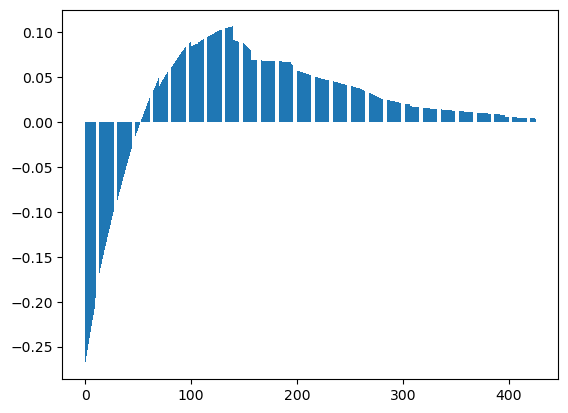

3.38

In [1442]:
compute_optimal_price(compet_info, 2.5 )

In [982]:
def compute_optimal_price(exp2): 
    company_distribution = {}
    for index, i in exp2.iterrows():
        generated_values, generated_quantiles = generate_distribution(i)
        company_distribution[index] = (generated_values, generated_quantiles)
    
    price_mins = []
    price_maxs = []
    for i in company_distribution:
        company_prices = company_distribution[i][0]
        price_mins.append(min(company_prices))
        price_maxs.append(max(company_prices))
    price_range = (max(price_mins), min(price_maxs))
    price_range = np.linspace(price_range[0], price_range[1], int((price_range[1]-price_range[0])/0.01) ).round(2)
    revs = []
    for i in price_range:
        rev = i-2.5
        for j in company_distribution:
            prob = pd.Series(company_distribution[j][1], index = company_distribution[j][0])[i]
            if isinstance(prob, pd.Series):
                prob = prob.iloc[0]
            rev = rev * (1-prob)
        revs.append(rev)
    range(len(revs))
    plt.bar(x = range(len(revs)), height = revs)
    plt.show()

In [962]:
# def find_competitors(to_be_guessed,new_df):
#     n = 0
#     for index, i in to_be_guessed.iterrows():
#         n += 1
#         if n == 10:
#             break
#         x_latitude = i['lat']  # replace with the actual latitude of point X
#         x_longitude = i['lng']  # replace with the actual longitude of point X
#         customer_type = i['customer_type']
#         date = pd.to_datetime(i['App Received Date'])
#         recent_date = date - pd.Timedelta(days=120)
#         recent_solar = new_df[(new_df['App Received Date'] > recent_date) & (new_df['App Received Date'] < date)].dropna(subset = ['lat','lng'])
#         recent_relevant_solar = recent_solar[recent_solar['customer_type'] == customer_type]
#         at_that_location = recent_relevant_solar.apply(lambda row: is_within_radius(row['lat'], row['lng']), axis = 1)
#         recent_nearby_relevant_solar = recent_relevant_solar[at_that_location ]
    
#         top_competitors = recent_nearby_relevant_solar['Installer Name'].value_counts()[:5].index
#         print(top_competitors)
                              

In [362]:
def is_within_radius(lat, long, radius= 3):
    """Check if a point is within a given radius (in miles) from point X"""
    distance = geodesic((x_latitude, x_longitude), (lat, long)).miles
    return distance <= radius


n = 0

for index, i in to_be_guessed.iterrows():
    n += 1
    if n == 10:
        break
    x_latitude = i['lat']  # replace with the actual latitude of point X
    x_longitude = i['lng']  # replace with the actual longitude of point X
    customer_type = i['customer_type']
    date = pd.to_datetime(i['App Received Date'])
    recent_date = date - pd.Timedelta(days=120)
    recent_solar = new_df[(new_df['App Received Date'] > recent_date) & (new_df['App Received Date'] < date)].dropna(subset = ['lat','lng'])
    recent_relevant_solar = recent_solar[recent_solar['customer_type'] == customer_type]
    at_that_location = recent_relevant_solar.apply(lambda row: is_within_radius(row['lat'], row['lng']), axis = 1)
    recent_nearby_relevant_solar = recent_relevant_solar[at_that_location ]
    
    top_competitors = recent_nearby_relevant_solar['Installer Name'].value_counts()[:5].index
    print(top_competitors)
                                                                                                 
    

In [483]:
exp = to_be_guessed.drop(['Cost/Watt','customer_type','App Received Date'], axis = 1)

In [949]:
lista = [q for q in quantiles]
exp2 = pd.DataFrame(columns = lista)
exp2
     

,5,10,15,20,25,30,35,40,44,49,54,60,65,70,75,80,85,90,95


In [950]:
for competitor in top_competitors:
    for i in range(exp.shape[0]):
        daf = exp.iloc[i:i+1,:]
        daf['Installer Name'] = competitor
        daf['Installer Name'] = daf['Installer Name'].astype('category')
        sum_tab = new_df[new_df['Installer Name'] == competitor][['installer_lat','installer_lng']].value_counts()
        print(sum_tab)
        summ = sum_tab.sum()
        instal_loc_dis = sum_tab/summ
        instal_locs = instal_loc_dis[instal_loc_dis >= 0.10]
        for j in instal_locs.index:
            lista = []
            daf[['installer_lat','installer_lng']] = j  
#         print(daf[['installer_lat','installer_lng']])
            for q in quantiles:
                lista.append(models[f"quantile_{q}"].predict(daf))
            lista = np.array(lista).flatten()
            y = pd.Series(lista)
            y.index = quantiles            
            exp2.loc[competitor + str(j)] = y 
            
    

installer_lat  installer_lng
40.49865       -74.53284        55818
37.79144       -122.40211       34824
35.23539       -120.61834       16324
37.79239       -122.39707         524
0.00000         0.00000           334
40.41209       -111.87377           9
37.44424       -122.14992           6
35.29082       -120.83920           3
36.91099       -120.19220           2
34.14956       -119.17458           2
35.16682       -120.46617           1
34.36543       -119.09563           1
33.86367       -117.59989           1
33.92216       -118.14167           1
38.64207       -121.51967           1
34.15246       -118.00065           1
37.71945       -121.02786           1
37.57445       -122.31942           1
37.57306       -122.37828           1
37.50771       -122.02523           1
34.16220       -117.51558           1
37.27977       -121.95481           1
37.13213       -121.67886           1
33.63386       -117.37949           1
35.29672       -120.72618           1
34.19791       -118.4

installer_lat  installer_lng
40.49865       -74.53284        55818
37.79144       -122.40211       34824
35.23539       -120.61834       16324
37.79239       -122.39707         524
0.00000         0.00000           334
40.41209       -111.87377           9
37.44424       -122.14992           6
35.29082       -120.83920           3
36.91099       -120.19220           2
34.14956       -119.17458           2
35.16682       -120.46617           1
34.36543       -119.09563           1
33.86367       -117.59989           1
33.92216       -118.14167           1
38.64207       -121.51967           1
34.15246       -118.00065           1
37.71945       -121.02786           1
37.57445       -122.31942           1
37.57306       -122.37828           1
37.50771       -122.02523           1
34.16220       -117.51558           1
37.27977       -121.95481           1
37.13213       -121.67886           1
33.63386       -117.37949           1
35.29672       -120.72618           1
34.19791       -118.4

installer_lat  installer_lng
40.49865       -74.53284        55818
37.79144       -122.40211       34824
35.23539       -120.61834       16324
37.79239       -122.39707         524
0.00000         0.00000           334
40.41209       -111.87377           9
37.44424       -122.14992           6
35.29082       -120.83920           3
36.91099       -120.19220           2
34.14956       -119.17458           2
35.16682       -120.46617           1
34.36543       -119.09563           1
33.86367       -117.59989           1
33.92216       -118.14167           1
38.64207       -121.51967           1
34.15246       -118.00065           1
37.71945       -121.02786           1
37.57445       -122.31942           1
37.57306       -122.37828           1
37.50771       -122.02523           1
34.16220       -117.51558           1
37.27977       -121.95481           1
37.13213       -121.67886           1
33.63386       -117.37949           1
35.29672       -120.72618           1
34.19791       -118.4

installer_lat  installer_lng
0.00000         0.00000         59952
33.08555       -117.12885        6449
33.53579       -117.35098        5921
32.91200       -117.14344        5057
39.68317       -121.83528        4156
                                ...  
37.55327       -122.49584           1
37.52946       -122.48490           1
37.50603       -122.47321           1
37.47140       -120.67744           1
62.82476       -164.68692           1
Name: count, Length: 1520, dtype: int64
installer_lat  installer_lng
0.00000         0.00000         59952
33.08555       -117.12885        6449
33.53579       -117.35098        5921
32.91200       -117.14344        5057
39.68317       -121.83528        4156
                                ...  
37.55327       -122.49584           1
37.52946       -122.48490           1
37.50603       -122.47321           1
37.47140       -120.67744           1
62.82476       -164.68692           1
Name: count, Length: 1520, dtype: int64
installer_lat  installer_l

installer_lat  installer_lng
33.48391       -117.22075       25556
33.69052       -117.30241        3770
33.53579       -117.35098        1911
37.27977       -121.95481         543
36.62423       -119.67173         282
0.00000         0.00000           215
33.63386       -117.37949          69
37.98484       -120.34515          54
37.29554       -121.89408          18
33.69466       -117.25196          13
33.19808       -117.24844           8
38.14264       -120.44359           6
32.83514       -116.87462           5
33.38252       -111.87482           5
36.93575       -121.78458           4
33.80489       -117.01873           2
33.13263       -116.98335           2
36.94029       -121.75089           1
38.99039       -121.10991           1
37.24470       -120.24277           1
37.13213       -121.67886           1
40.45808       -124.10720           1
37.34128       -120.40658           1
33.80886       -116.71212           1
34.36415       -117.30984           1
34.02914       -117.9

installer_lat  installer_lng
33.48391       -117.22075       25556
33.69052       -117.30241        3770
33.53579       -117.35098        1911
37.27977       -121.95481         543
36.62423       -119.67173         282
0.00000         0.00000           215
33.63386       -117.37949          69
37.98484       -120.34515          54
37.29554       -121.89408          18
33.69466       -117.25196          13
33.19808       -117.24844           8
38.14264       -120.44359           6
32.83514       -116.87462           5
33.38252       -111.87482           5
36.93575       -121.78458           4
33.80489       -117.01873           2
33.13263       -116.98335           2
36.94029       -121.75089           1
38.99039       -121.10991           1
37.24470       -120.24277           1
37.13213       -121.67886           1
40.45808       -124.10720           1
37.34128       -120.40658           1
33.80886       -116.71212           1
34.36415       -117.30984           1
34.02914       -117.9

installer_lat  installer_lng
33.48391       -117.22075       25556
33.69052       -117.30241        3770
33.53579       -117.35098        1911
37.27977       -121.95481         543
36.62423       -119.67173         282
0.00000         0.00000           215
33.63386       -117.37949          69
37.98484       -120.34515          54
37.29554       -121.89408          18
33.69466       -117.25196          13
33.19808       -117.24844           8
38.14264       -120.44359           6
32.83514       -116.87462           5
33.38252       -111.87482           5
36.93575       -121.78458           4
33.80489       -117.01873           2
33.13263       -116.98335           2
36.94029       -121.75089           1
38.99039       -121.10991           1
37.24470       -120.24277           1
37.13213       -121.67886           1
40.45808       -124.10720           1
37.34128       -120.40658           1
33.80886       -116.71212           1
34.36415       -117.30984           1
34.02914       -117.9

installer_lat  installer_lng
33.75500       -117.81488       7372
33.86797       -118.06874       1288
34.15246       -118.00065          3
35.29672       -120.72618          1
37.71596       -121.90113          1
Name: count, dtype: int64
installer_lat  installer_lng
33.75500       -117.81488       7372
33.86797       -118.06874       1288
34.15246       -118.00065          3
35.29672       -120.72618          1
37.71596       -121.90113          1
Name: count, dtype: int64
installer_lat  installer_lng
33.75500       -117.81488       7372
33.86797       -118.06874       1288
34.15246       -118.00065          3
35.29672       -120.72618          1
37.71596       -121.90113          1
Name: count, dtype: int64
installer_lat  installer_lng
33.75500       -117.81488       7372
33.86797       -118.06874       1288
34.15246       -118.00065          3
35.29672       -120.72618          1
37.71596       -121.90113          1
Name: count, dtype: int64
installer_lat  installer_lng
33.75500   

installer_lat  installer_lng
42.19689       -71.84549        29114
33.64786       -117.92050         551
35.98708       -118.89493         381
42.25085       -71.76830          228
0.00000         0.00000           210
36.81515       -121.77790         206
36.64794       -121.63044         133
34.10152       -118.05584          45
32.89730       -117.20231          28
34.17708       -118.61518          15
37.18428       -121.83658          12
32.79526       -117.07317          10
42.26815       -71.61402            8
34.30922       -118.69041           5
37.71945       -121.02786           3
37.36015       -120.11581           2
35.23539       -120.61834           2
33.75500       -117.81488           2
33.82406       -118.11236           1
37.99344       -122.03532           1
41.37627       -73.45904            1
33.63375       -117.87504           1
33.62328       -117.93022           1
32.96354       -117.12622           1
42.62915       -71.33674            1
Name: count, dtype: i

installer_lat  installer_lng
42.19689       -71.84549        29114
33.64786       -117.92050         551
35.98708       -118.89493         381
42.25085       -71.76830          228
0.00000         0.00000           210
36.81515       -121.77790         206
36.64794       -121.63044         133
34.10152       -118.05584          45
32.89730       -117.20231          28
34.17708       -118.61518          15
37.18428       -121.83658          12
32.79526       -117.07317          10
42.26815       -71.61402            8
34.30922       -118.69041           5
37.71945       -121.02786           3
37.36015       -120.11581           2
35.23539       -120.61834           2
33.75500       -117.81488           2
33.82406       -118.11236           1
37.99344       -122.03532           1
41.37627       -73.45904            1
33.63375       -117.87504           1
33.62328       -117.93022           1
32.96354       -117.12622           1
42.62915       -71.33674            1
Name: count, dtype: i

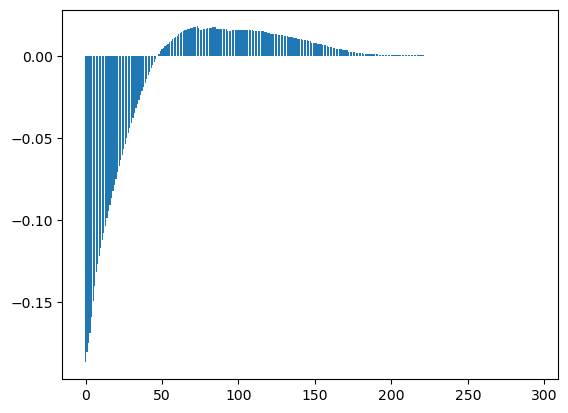

In [951]:
company_distribution = {}
for index, i in exp2.iterrows():
    generated_values, generated_quantiles = generate_distribution(i)
    company_distribution[index] = (generated_values, generated_quantiles)
    
price_mins = []
price_maxs = []
for i in company_distribution:
    company_prices = company_distribution[i][0]
    price_mins.append(min(company_prices))
    price_maxs.append(max(company_prices))
price_range = (max(price_mins), min(price_maxs))
price_range = np.linspace(price_range[0], price_range[1], int((price_range[1]-price_range[0])/0.01) ).round(2)
revs = []
for i in price_range:
    rev = i-2.5
    for j in company_distribution:
        prob = pd.Series(company_distribution[j][1], index = company_distribution[j][0])[i]
        if isinstance(prob, pd.Series):
            prob = prob.iloc[0]
        rev = rev * (1-prob)
    revs.append(rev)
range(len(revs))
plt.bar(x = range(len(revs)), height = revs)
plt.show()

In [ ]:
sum_tab = X[X['Installer Name'] == 'sunrun'][['installer_lat','installer_lng']].value_counts()
summ = sum_tab.sum()
instal_loc_dis = sum_tab/summ
instal_locs= instal_loc_dis[instal_loc_dis >= 0.05]
for i in instal_locs.index:

In [ ]:
quantiles = (np.linspace(0.05, 0.95, 19)*100).astype(int)

df = pd.DataFrame()
for q in quantiles:
    df[f"quantile_{q }"] = models[f"quantile_{q}"].predict(X_test)

import numpy as np

# Your original array
values = df.iloc[0,].round(2)

# List to store the generated values
generated_values = []
generated_quantiles = []

# Iterate through each pair of neighboring values
for i in range(len(values)-1):
    # Generate 100 values between each pair (excluding the endpoint to avoid duplication)
    num_computation = int(round((values[i + 1]-values[i])/0.01,0))
    print(values[i +1], values[i], num_computation)
    if num_computation < 0:
        continue
    print(num_computation)
    interval_values = np.linspace(values[i], values[i + 1], num = num_computation, endpoint=False)
    interval_quantile = np.linspace(quantiles[i],quantiles[i + 1], num=num_computation, endpoint=False)
    print(interval_values.shape)
    generated_values.extend(interval_values)
    generated_quantiles.extend(interval_quantile)

# Add the last value from the original array
generated_values.append(values[-1])
generated_quantiles.append(quantiles[-1])

# Convert the list to a NumPy array
generated_array = np.array(generated_values)
generated_quantiles = np.array(generated_quantiles)/100

plt.figure(figsize=(8, 6))
plt.plot(generated_array , generated_quantiles, marker='o')
plt.xlabel('Quantiles')
plt.ylabel('Cumulative Density')
plt.title('Cumulative Density Distribution')
plt.grid(True)
plt.show()